My First Collaborative filtering starter with Keras



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

RegularSeasonCompactResults.csv
RegularSeasonDetailedResults.csv
Seasons.csv
Teams.csv
TourneyCompactResults.csv
TourneyDetailedResults.csv
TourneySeeds.csv
TourneySlots.csv
sample_submission.csv



In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from keras.layers import Input, Dense, Dropout, Flatten, Embedding, merge
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import Model

Using TensorFlow backend.


In [4]:
dr = pd.read_csv("../input/RegularSeasonDetailedResults.csv")

In [5]:
dr.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [6]:
simple_df_1 = pd.DataFrame()
simple_df_1[["team1", "team2"]] =dr[["Wteam", "Lteam"]].copy()
simple_df_1["pred"] = 1

simple_df_2 = pd.DataFrame()
simple_df_2[["team1", "team2"]] =dr[["Lteam", "Wteam"]]
simple_df_2["pred"] = 0

simple_df = pd.concat((simple_df_1, simple_df_2), axis=0)
simple_df.head()

,team1,team2,pred
0,1104,1328,1
1,1272,1393,1
2,1266,1437,1
3,1296,1457,1
4,1400,1208,1


In [7]:
n = simple_df.team1.nunique()
n

355

In [8]:
trans_dict = {t: i for i, t in enumerate(simple_df.team1.unique())}
simple_df["team1"] = simple_df["team1"].apply(lambda x: trans_dict[x])
simple_df["team2"] = simple_df["team2"].apply(lambda x: trans_dict[x])
simple_df.head()

,team1,team2,pred
0,0,67,1
1,1,164,1
2,2,93,1
3,3,221,1
4,4,110,1


In [9]:
train = simple_df.values
np.random.shuffle(train)

In [10]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype="int64", name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [11]:
n_factors = 50

team1_in, t1 = embedding_input("team1_in", n, n_factors, 1e-4)
team2_in, t2 = embedding_input("team2_in", n, n_factors, 1e-4)

b1 = create_bias(team1_in, n)
b2 = create_bias(team2_in, n)

In [12]:
x = merge([t1, t2], mode="dot")
x = Flatten()(x)
x = merge([x, b1], mode="sum")
x = merge([x, b2], mode="sum")
x = Dense(1, activation="sigmoid")(x)
model = Model([team1_in, team2_in], x)
model.compile(Adam(0.001), loss="binary_crossentropy")

In [13]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
team1_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
team2_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         17750       team1_in[0][0]                   
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         17750       team2_in[0][0]                   
___________________________________________________________________________________________

In [14]:
history = model.fit([train[:, 0], train[:, 1]], train[:, 2], batch_size=64, nb_epoch=10, verbose=2)

Epoch 1/10
10s - loss: 0.6508
Epoch 2/10
9s - loss: 0.6047
Epoch 3/10
9s - loss: 0.5933
Epoch 4/10
9s - loss: 0.5894
Epoch 5/10
9s - loss: 0.5881
Epoch 6/10
9s - loss: 0.5875
Epoch 7/10
9s - loss: 0.5872
Epoch 8/10
9s - loss: 0.5867
Epoch 9/10
9s - loss: 0.5866
Epoch 10/10
9s - loss: 0.5862


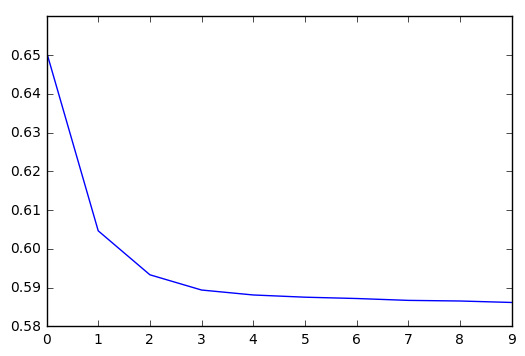

In [15]:
plt.plot(history.history["loss"])
plt.show()

In [16]:
sub = pd.read_csv("../input/sample_submission.csv")
sub["team1"] = sub["id"].apply(lambda x: trans_dict[int(x.split("_")[1])])
sub["team2"] = sub["id"].apply(lambda x: trans_dict[int(x.split("_")[2])])
sub.head()

,id,pred,team1,team2
0,2013_1103_1107,0.5,230,294
1,2013_1103_1112,0.5,230,97
2,2013_1103_1125,0.5,230,13
3,2013_1103_1129,0.5,230,190
4,2013_1103_1137,0.5,230,192


In [17]:
sub["pred"] = model.predict([sub.team1, sub.team2])
sub = sub[["id", "pred"]]
sub.head()

,id,pred
0,2013_1103_1107,0.742206
1,2013_1103_1112,0.165811
2,2013_1103_1125,0.560741
3,2013_1103_1129,0.524108
4,2013_1103_1137,0.737480


In [18]:
sub.to_csv("CF.csv", index=False)